In [1]:
"""
*Uncomment if running on colab* 
Set Runtime -> Change runtime type -> Under Hardware Accelerator select GPU in Google Colab 
"""
!git clone https://github.com/maxudong1993/imagefusion_pytorch.git
!mv imagefusion_pytorch/* ./
!pip install sporco

Cloning into 'imagefusion_pytorch'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 112 (delta 3), reused 7 (delta 1), pack-reused 59
Receiving objects: 100% (112/112), 8.37 MiB | 46.86 MiB/s, done.
Resolving deltas: 100% (7/7), done.
     |████████████████████████████████| 4.5MB 29.2MB/s 
     |████████████████████████████████| 2.6MB 42.4MB/s 


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
from imageio import imread

import torch
import torch.nn
from torchvision.models.vgg import vgg19

import matplotlib.pyplot as plt
%matplotlib inline

## Loading the images

In [21]:
idx = 1

# gray = imread('IV_images/VIS%d.png' % idx)
# ir = imread('IV_images/IR%d.png' % idx)
gray = imread('/content/data/medical/medA.jpg')
ir = imread('/content/data/medical/medB.jpg')

## Using the method immediately

/content/vggfusion.py:8: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
/content/vggfusion.py:8: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)


Text(0.5, 1.0, 'Fusion')

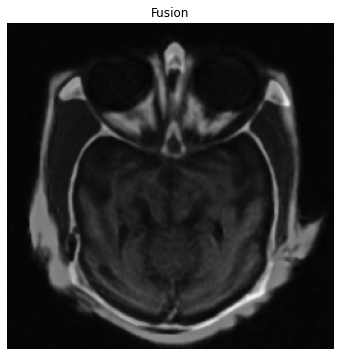

In [22]:
from vggfusion import fuse

plt.figure(figsize=(6, 6))
plt.imshow(fuse(gray, ir), 'gray')
plt.axis('off')
plt.title('Fusion')

## Visualizing the weight maps

/content/vggfusion.py:8: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
/content/vggfusion.py:8: DeprecationWarning: Function sporco.util.tikhonov_filter is deprecated; please use function sporco.signal.tikhonov_filter instead.
  return tikhonov_filter(s, lda, npad)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


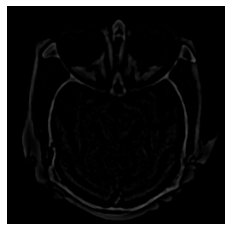

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


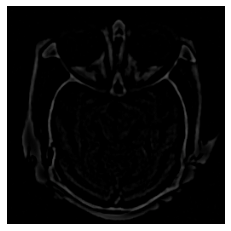

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


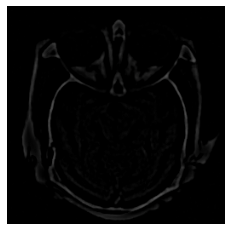

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


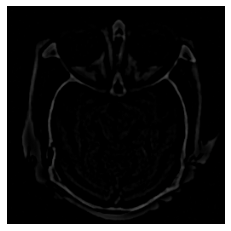

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


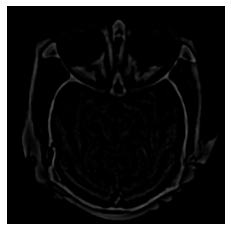

In [23]:
from vggfusion import *

npad = 16
lda = 5
graylow, grayhigh = lowpass(gray.astype(np.float32)/255, lda, npad)
irlow, irhigh = lowpass(ir.astype(np.float32)/255, lda, npad)

grayhigh3 = c3(grayhigh)
irhigh3 = c3(irhigh)

model = vgg19(True).cuda().eval()

gray_in = torch.from_numpy(grayhigh3).cuda()
ir_in = torch.from_numpy(irhigh3).cuda()
relus = [2, 7, 12, 21]
unit_relus = [1, 2, 4, 8]

relus_gray = get_activation(model, relus, gray_in)
relus_ir = get_activation(model, relus, ir_in)

gray_feats = [l1_features(out) for out in relus_gray]
ir_feats = [l1_features(out) for out in relus_ir]

saliencies = []
saliency_max = None
for idx in range(len(relus)):
    saliency_current = fusion_strategy(gray_feats[idx], ir_feats[idx], grayhigh, irhigh, unit_relus[idx])
    saliencies.append(saliency_current)
    
    if saliency_max is None:
        saliency_max = saliency_current
    else:
        saliency_max = np.maximum(saliency_max, saliency_current)
    
    plt.imshow(saliency_current, 'gray')
    plt.axis('off')
    plt.show()

plt.imshow(saliency_max, 'gray')
plt.axis('off')
plt.show()

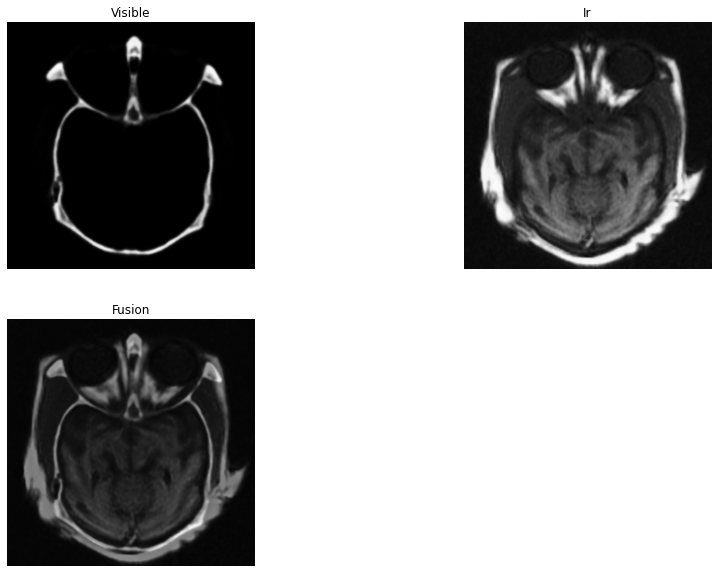

In [24]:
import matplotlib
low_fused = (graylow + irlow) / 2
high_fused = saliency_max

fusion = low_fused + high_fused

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.imshow(gray, 'gray')
plt.axis('off')
plt.title('Visible')

plt.subplot(2, 2, 2)
plt.imshow(ir, 'gray')
plt.axis('off')
plt.title('Ir')

plt.subplot(2, 2, 3)
plt.imshow(fusion, 'gray')
plt.axis('off')
plt.title('Fusion')
#save result
fusion = np.clip(fusion, 0, 1)
# plt.imsave('/content/data/clocks/clock_ICPR_afterRGB.png', fusion, vmin=0, vmax=255,cmap ='gray')
plt.imsave('/content/data/medical/med_ICPR_afterRGB.png', fusion)